In [1]:
# pre-setting and load prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

protein_name = 'AF_preds'
cluster_id = 1
N_decoys = 1000
cluster = f'cluster{cluster_id}_8A_manual_rescale'
HDX_fpath = '/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/HDX_files/Wuhan_icoHu23_revised.xlsx'
pred_dir = '/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/predictions'

dfs = []
epochs = [60, 70, 80, 90, 100]
for i,epoch in enumerate(epochs):
    fpath = f'{pred_dir}/{protein_name}/HDX_pred_GearNet56_{protein_name}_epoch{epoch}.csv'
    df = pd.read_csv(fpath)
    print(df.shape)
    dfs.append(df)
merged_df = pd.concat(dfs, axis=0)
average_df = merged_df.groupby(['Batch', 'Chain', 'Range', 'Y_True'])['Y_Pred'].mean().reset_index()

print(average_df.head())
print(average_df.shape)

(4800, 5)
(4800, 5)
(4800, 5)
(4800, 5)
(4800, 5)
                                     Batch  Chain    Range  Y_True    Y_Pred
0  fold_1203_wuhan_icohu104_seed10_model_0      0  348-361     0.0  0.304442
1  fold_1203_wuhan_icohu104_seed10_model_0      0  351-361     0.0  0.334257
2  fold_1203_wuhan_icohu104_seed10_model_0      0  369-374     0.0  0.396051
3  fold_1203_wuhan_icohu104_seed10_model_0      0  375-387     0.0  0.304691
4  fold_1203_wuhan_icohu104_seed10_model_0      0  388-392     0.0  0.282035
(4800, 5)


In [2]:
diff_df = pd.DataFrame()
for seed in range(1,11):
    for model in range(5):
        temp_df = average_df[average_df['Batch'] == f'fold_1203_wuhan_icohu104_seed{seed}_model_{model}']
        temp_apo_df = average_df[average_df['Batch'] == f'fold_1203_wuhan_icohu104_seed{seed}_model_{model}_ABC']

        temp_diff = temp_df.set_index('Range')['Y_Pred'] - temp_apo_df.set_index('Range')['Y_Pred']
        temp_diff = temp_diff.reset_index()
        temp_diff['Batch']=f'fold_1203_wuhan_icohu104_seed{seed}_model_{model}'
        diff_df = pd.concat([diff_df, temp_diff], ignore_index=True)

display(diff_df.head())
print(diff_df.shape)

,Range,Y_Pred,Batch
0,348-361,0.023230,fold_1203_wuhan_icohu104_seed1_model_0
1,351-361,0.025830,fold_1203_wuhan_icohu104_seed1_model_0
2,369-374,-0.007365,fold_1203_wuhan_icohu104_seed1_model_0
3,375-387,0.021276,fold_1203_wuhan_icohu104_seed1_model_0
4,388-392,0.036221,fold_1203_wuhan_icohu104_seed1_model_0


(2400, 3)


In [3]:
timepoints = [1.35,2.85]
cluster_id = 1

def get_true_diff(HDX_fpath, apo_states, complex_states, cluster_id):
    def get_weighted_uptake(HDX_df, protein, state, correction):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        if cluster_id == 0:
            temp_HDX_df = temp_HDX_df[temp_HDX_df['log_t']<timepoints[0]]
        elif cluster_id == 1:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']<timepoints[1]) & (temp_HDX_df['log_t']>=timepoints[0])]
        elif cluster_id == 2:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']>=timepoints[1])]
        else:
            raise ValueError('Invalid cluster_id')
        
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])

        exposures = temp_HDX_df['exposure'].unique()
        unweighted_RFU = {time:{} for time in exposures}
        for time in exposures:
            for index, row in temp_HDX_df[temp_HDX_df['exposure']==time].iterrows():
                #chain_id = int(row['Chain'])
                unweighted_RFU[time][f'{row["start"]+correction}-{row["end"]+correction}'] = row['RFU']

        grouped = temp_HDX_df.groupby(['start', 'end'])
        weighted_uptake = grouped['RFU'].mean().to_numpy()/100
        unique_pairs = grouped.groups.keys()
        x_label = [f'{start+correction}-{end+correction}' for start, end in unique_pairs]

        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    true_apo, true_complex = {}, {}
    apo_mtx, complex_mtx = {}, {}

    protein, state, correction = apo_states[0], apo_states[1], apo_states[2]
    uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_apo[l] = u
    apo_mtx.update(U_apo_mtx)

    protein, state, correction = complex_states[0], complex_states[1], complex_states[2]
    uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_complex[l] = u
    complex_mtx.update(U_complex_mtx)

    true_diff = {}
    diff_mtx = {}
    for key in true_apo.keys():
        if key in true_complex:
            true_diff[key] = -(true_complex[key] - true_apo[key])
            diff_mtx[key] = {t: complex_mtx[t][key] - apo_mtx[t][key] for t in apo_mtx if key in apo_mtx[t] and key in complex_mtx[t]}
    
    print('Common peptides num:', len(true_diff.keys()))
    return true_diff, diff_mtx

def plot_HDX_diff(true_diff, diff_mtx, size=(10, 6)):
    plt.figure(figsize=size)
    x_labels = list(true_diff.keys())
    x_positions = np.arange(len(x_labels))  # numerical positions for x-axis

    diff = np.array(list(true_diff.values()))
    diff_neg = diff[diff<0]
    mean_diff = np.mean(diff_neg)
    hdx_epitope_id = np.where(diff<mean_diff)[0]
    hdx_epitope_pep = [x_labels[i] for i in hdx_epitope_id]

    plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
    all_times = set()
    for diffs in diff_mtx.values():
        all_times.update(diffs.keys())
    sorted_times = sorted(all_times, key=lambda x: float(x))
    for time in sorted_times:
        time_values = [diff_mtx[label].get(time, 0) / 100 for label in x_labels]
        plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
    plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=1, markersize=4)
    plt.ylabel('RFU difference')
    plt.axhline(y=mean_diff, color='r', linestyle='--', label='Epitope cutoff')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    #plt.grid(True)
    plt.legend()
    plt.show()

    return hdx_epitope_id, hdx_epitope_pep, sorted_times

('Wuhan_cov19', 'apo', 0, None) ('Wuhan_cov19', 'complex', 0, None)
Common peptides num: 48


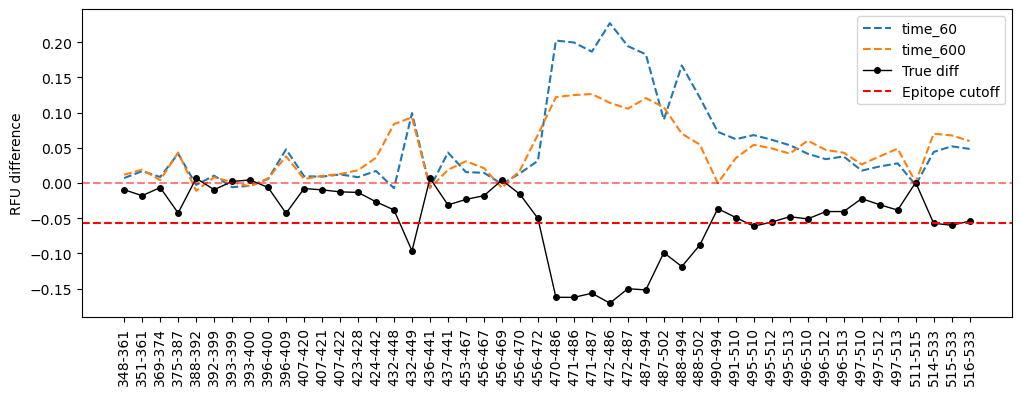

In [4]:
apo_states = {
    'protein': 'Wuhan_cov19',
    'state': 'apo',
    'correction': 0,
    'structure': None
}
complex_states = {
    'protein': 'Wuhan_cov19',
    'state': 'complex',
    'correction': 0,
    'structure': None
}
input_apo_states = [tuple(apo_states.values())]
input_complex_states = [tuple(complex_states.values())]

hdx_epitope_peps = []
hdx_true_diffs = []
for apo, complex in zip(input_apo_states, input_complex_states):
    print(apo, complex)
    true_diff, diff_mtx = get_true_diff(HDX_fpath, apo, complex, cluster_id)
    epitope_id, epitope_pep, hdx_times = plot_HDX_diff(true_diff, diff_mtx, size=(12,4))
    hdx_true_diffs.append(true_diff)
    hdx_epitope_peps.append(epitope_pep)

In [5]:
# ouput the HDX epitope peptides
def to_ranges(numbers):
    if not numbers:
        return []
    
    ranges = []
    start = numbers[0]
    prev = numbers[0]

    for num in numbers[1:]:
        if num == prev + 1:
            # Continue the current range
            prev = num
        else:
            # End of the current range
            ranges.append(f"{start}-{prev}" if start != prev else f"{start}")
            start = num
            prev = num
    
    # Add the last range
    ranges.append(f"{start}-{prev}" if start != prev else f"{start}")
    return ranges

def to_numbers(range_list):
    all_numbers = set()
    for r in range_list:
        start, end = map(int, r.split('-'))
        all_numbers.update(range(start, end + 1))
    return sorted(all_numbers)

for i, epitopes in enumerate(hdx_epitope_peps):
    all_numbers = to_numbers(epitopes)
    ranges = to_ranges(all_numbers)
    print(f'Epitopes for {input_apo_states[i][3]} and {input_complex_states[i][3]}:')
    print(ranges)

Epitopes for None and None:
['432-449', '470-510', '514-533']


In [6]:
# HDX score calculation
from tqdm import tqdm

def root_mean_square_error(y_true, y_pred, error_limit=1):
    return np.mean((((y_true - y_pred)/error_limit) ** 2))

def prepare_data(df, complex_batch, apo_states, complex_states, hdx_true_diffs, hdx_epitope_peps=None):
    truth = []
    pred = []
    if complex_batch not in df['Batch'].values:
        print(f'{complex_batch} not found in the prediction data')
        return None, None
    if hdx_epitope_peps is None:
        hdx_epitope_peps = [list(hdx_dict.keys()) for hdx_dict in hdx_true_diffs]
    for apo_state, complex_state, epitope_peps, hdx_dict in zip(apo_states, complex_states, hdx_epitope_peps, hdx_true_diffs):
        complex_df = df[df['Batch']==complex_batch]

        for pep in epitope_peps:
            if pep in complex_df['Range'].values:
                #print(pep)
                pred_diff = complex_df.loc[complex_df['Range']==pep, 'Y_Pred'].values[0]
                true_diff = hdx_dict[pep]
                truth.append(true_diff)
                pred.append(pred_diff)
    return np.array(truth), np.array(pred)

HDX_scores = []
complex_batch_list = diff_df['Batch'].unique()

for complex_batch in tqdm(complex_batch_list):
    y_true, y_pred = prepare_data(diff_df, complex_batch, input_apo_states, input_complex_states, hdx_true_diffs, hdx_epitope_peps=hdx_epitope_peps)
    if y_true is None:
        continue
    hdx_score = root_mean_square_error(y_true, y_pred)
    HDX_scores.append(hdx_score)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 162.54it/s]


In [14]:
rank_df = pd.DataFrame()
rank_df['Batch'] = complex_batch_list
rank_df['HDX_score'] = HDX_scores

AF_df = pd.read_csv(f'/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/AF_50/AF_rmsd.csv')
AF_df = AF_df.transpose()
print(AF_df.shape)
AF_df.columns = [f'cluster{i}' for i in range(1, 4)]
AF_df.reset_index(inplace=True)
AF_df.rename(columns={'index': 'Batch'}, inplace=True)
AF_df['min_rmsd'] = AF_df[['cluster1', 'cluster2', 'cluster3']].min(axis=1)
display(AF_df.sort_values(by='cluster1', ascending=True).head(10))

display(rank_df.sort_values(by='HDX_score', ascending=True).head(10))

(51, 3)


,Batch,cluster1,cluster2,cluster3,min_rmsd
21,fold_1203_wuhan_icohu104_seed4_model_1.pdb,16.423,66.998,57.443,16.423
50,min_rmsd,16.423,19.710,25.919,16.423
29,fold_1203_wuhan_icohu104_seed5_model_4.pdb,20.647,69.375,53.347,20.647
45,fold_1203_wuhan_icohu104_seed9_model_0.pdb,39.805,38.080,41.082,38.080
5,fold_1203_wuhan_icohu104_seed1_model_0.pdb,43.079,36.284,39.794,36.284
33,fold_1203_wuhan_icohu104_seed6_model_3.pdb,44.594,32.305,73.131,32.305
7,fold_1203_wuhan_icohu104_seed1_model_2.pdb,46.523,72.980,37.902,37.902
27,fold_1203_wuhan_icohu104_seed5_model_2.pdb,47.222,27.882,71.429,27.882
46,fold_1203_wuhan_icohu104_seed9_model_1.pdb,48.923,69.710,25.919,25.919
0,fold_1203_wuhan_icohu104_seed10_model_0.pdb,49.428,72.712,26.885,26.885


,Batch,HDX_score
26,fold_1203_wuhan_icohu104_seed6_model_1,0.008794
22,fold_1203_wuhan_icohu104_seed5_model_2,0.009458
20,fold_1203_wuhan_icohu104_seed5_model_0,0.012301
34,fold_1203_wuhan_icohu104_seed7_model_4,0.012787
44,fold_1203_wuhan_icohu104_seed9_model_4,0.012946
23,fold_1203_wuhan_icohu104_seed5_model_3,0.013035
8,fold_1203_wuhan_icohu104_seed2_model_3,0.013282
45,fold_1203_wuhan_icohu104_seed10_model_0,0.013339
47,fold_1203_wuhan_icohu104_seed10_model_2,0.013405
6,fold_1203_wuhan_icohu104_seed2_model_1,0.013482


### Clustering AF predictions

In [8]:
import sys
sys.path.append('/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/HDXRank')
from tool.pdb2sql.StructureSimilarity import StructureSimilarity
from tool.pdb2sql import pdb2sql
from tool.pdb2sql.superpose import superpose
from tool.pdb2sql.many2sql import many2sql

from Bio.PDB import *
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os

In [9]:
clustering_setting = {
    'protein_name': '',
    'N': 50,
    'min_leaf_size': 2,
    'bindingsite_cutoff': 10.0, # use a coarse cutoff that allows different orientations at a close binding site
    'pose_rmsd_cutoff': 15.0,
    'atom_type_list': ['CA'],
    'lig_chains': ['D', 'E']
}
os.chdir('/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/AF_50/superimpose_pdb')
AF_dir = f'/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/AF_50/pdb'
pdb_fpaths = [os.path.join(AF_dir, file) for file in os.listdir(AF_dir) if file.endswith('.pdb')]
lrmsd_mtx = np.zeros((len(pdb_fpaths), len(pdb_fpaths)))

coords = []
for pdb in pdb_fpaths:
    mobile = pdb2sql(pdb)
    target = pdb2sql(pdb_fpaths[0])
    overlap_mobile = superpose(mobile, target, export=True, chainID=['A','B','C'])
    overlap_mobile_lig = overlap_mobile.get('x,y,z', chainID=clustering_setting['lig_chains'])
    coords.append(np.array(overlap_mobile_lig))
coords = np.array(coords)

for i in range(len(pdb_fpaths)):
    ref_coords = coords[i]
    for j in range(len(pdb_fpaths)):
        if i <= j:
            continue
        check_coords = coords[j]
        lrmsd_mtx[i, j] = StructureSimilarity.get_rmsd(ref_coords, check_coords)
        lrmsd_mtx[j, i] = lrmsd_mtx[i, j]
print(lrmsd_mtx)

[[  0.    133.893 131.716 ... 115.476 115.041 132.413]
 [133.893   0.      3.536 ...  92.5    93.549   8.249]
 [131.716   3.536   0.    ...  91.693  92.701   8.315]
 ...
 [115.476  92.5    91.693 ...   0.      3.519  89.518]
 [115.041  93.549  92.701 ...   3.519   0.     90.751]
 [132.413   8.249   8.315 ...  89.518  90.751   0.   ]]


<Figure size 1000x600 with 0 Axes>

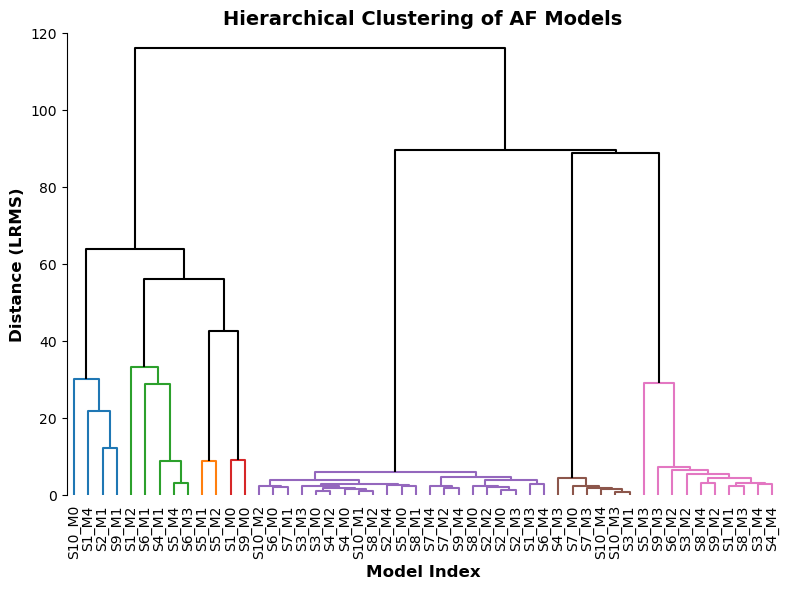

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster,set_link_color_palette
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import numpy as np

# Perform hierarchical clustering
condensed_rmsd = squareform(lrmsd_mtx)
linkage_matrix = linkage(condensed_rmsd, method='average')

num_clusters = 7
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Plot the dendrogram with cluster colors
plt.figure(figsize=(10, 6))
custom_palette = ["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:brown", "tab:pink"]
set_link_color_palette(custom_palette)
cluster_color_map = {cluster: color for cluster, color in zip(np.unique(clusters), custom_palette)}

custom_labels = []
for file in pdb_fpaths:
    pdb_splits = os.path.basename(file).split('_')
    seed = pdb_splits[-3].replace('seed', 'S')
    label = seed+'_M'+pdb_splits[-1][0]
    custom_labels.append(label)

# Plot the dendrogram with unified cluster colors
fig, ax = plt.subplots(figsize=(8, 6))
dendro = dendrogram(
    linkage_matrix,
    labels=custom_labels,
    color_threshold=linkage_matrix[-(num_clusters - 1), 2],
    leaf_rotation=90,
    leaf_font_size=10,
    above_threshold_color="black",  # Color for branches above the clustering threshold
    ax=ax,
)

for spine_name, spine in ax.spines.items():
    if spine_name != 'left':
        spine.set_visible(False)

plt.title("Hierarchical Clustering of AF Models", fontsize=14, fontweight="bold")
plt.xlabel("Model Index", fontsize=12, fontweight="bold")
plt.ylabel("Distance (LRMS)", fontsize=12, fontweight="bold")
plt.ylim(0,120)
plt.tight_layout()
#plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/AF_50/AF_Clustering_dendrogram.png', dpi=300, transparent=True)
plt.show()
set_link_color_palette(None)

In [22]:
cluster_df = pd.DataFrame()
cluster_df['Batch'] = [os.path.basename(pdb)[:-4] for pdb in pdb_fpaths]
cluster_df['Cluster'] = clusters


AF_df['Batch'] = AF_df['Batch'].str.replace('.pdb', '', regex=False)

# Merge rank_df and cluster_df on 'Batch'
merge_df = pd.merge(rank_df, cluster_df[['Batch', 'Cluster']], on='Batch', how='left')

# Merge the result with AF_df on 'Batch'
merge_df = pd.merge(merge_df, AF_df[['Batch', 'min_rmsd']], on='Batch', how='left')

display(merge_df.sort_values(by='HDX_score', ascending=True).head(10))

,Batch,HDX_score,Cluster,min_rmsd
26,fold_1203_wuhan_icohu104_seed6_model_1,0.008794,2,42.428
22,fold_1203_wuhan_icohu104_seed5_model_2,0.009458,3,27.882
20,fold_1203_wuhan_icohu104_seed5_model_0,0.012301,5,120.816
34,fold_1203_wuhan_icohu104_seed7_model_4,0.012787,5,114.115
44,fold_1203_wuhan_icohu104_seed9_model_4,0.012946,5,112.783
23,fold_1203_wuhan_icohu104_seed5_model_3,0.013035,7,105.799
8,fold_1203_wuhan_icohu104_seed2_model_3,0.013282,5,116.757
45,fold_1203_wuhan_icohu104_seed10_model_0,0.013339,1,26.885
47,fold_1203_wuhan_icohu104_seed10_model_2,0.013405,5,113.395
6,fold_1203_wuhan_icohu104_seed2_model_1,0.013482,1,19.710


In [8]:
cluster_df = pd.DataFrame()
cluster_df['Batch'] = [os.path.basename(pdb)[:-4] for pdb in pdb_fpaths]
cluster_df['Cluster'] = clusters

merge_df = pd.merge(rank_df, cluster_df, on='Batch')
mean_HDX_scores = merge_df.groupby('Cluster')['HDX_score'].mean().reset_index()
min_score_cluster = mean_HDX_scores.loc[mean_HDX_scores['HDX_score'].idxmin()]['Cluster']
print(mean_HDX_scores)

display(merge_df[merge_df['Cluster']==3].sort_values(by='HDX_score', ascending=True).head(10))

native_fpath = '/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/structure/8elj.pdb'
target = pdb2sql(native_fpath)
target = target(chainID=['C', 'W', 'X'])
num_chainC_atoms = len(target.get('chainID', chainID=['C']))
chainB = ['B'] * num_chainC_atoms
target.update('chainID', chainB, chainID=['C'])
print(target.get_chains())

for i,row in merge_df[merge_df['Cluster']==3].sort_values(by='HDX_score', ascending=True).iterrows():
    pdb_path = os.path.join(AF_dir, row['Batch']+'.pdb')
    mobile = pdb2sql(pdb_path)
    mobile = mobile(chainID=['B','D', 'E'])
    overlap_mobile = superpose(mobile, target, export=False, chainID=['B'], resSeq=list(range(319,542)))

    mobile_lig = overlap_mobile(chainID=['D', 'E'])
    target_lig = target(chainID=['W', 'X'])

    pdbdata = [mobile_lig.sql2pdb(), target_lig.sql2pdb()]
    manydb = many2sql(pdbdata)
    data = manydb().get_intersection('x,y,z', match=['name', 'resname', 'resSeq'])

    rmsd = StructureSimilarity.get_rmsd(np.array(data[0]), np.array(data[1]))
    print(row['Batch'], rmsd)

NameError: name 'rank_df' is not defined

In [12]:
from DockQ.DockQ import load_PDB, run_on_all_native_interfaces

def merge_chains(model, chains_to_merge):
    for chain in chains_to_merge[1:]:
        for i, res in enumerate(model[chain]):
            res.id = (chain, res.id[1], res.id[2])
            model[chains_to_merge[0]].add(res)
        model.detach_child(chain)
    model[chains_to_merge[0]].id = "".join(chains_to_merge)
    return model
native_fpath = '/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/structure/8elj.pdb'
mapping = {"C": "C", "WX": "DE"}
native = load_PDB(native_fpath)
native = merge_chains(native, ["W", "X"])
cluster_df['dockq1'] = np.nan

#for i,row in merge_df[merge_df['Cluster']==3].sort_values(by='HDX_score', ascending=True).iterrows():
for i,row in cluster_df.iterrows():   
    pdb_path = os.path.join(AF_dir, row['Batch']+'.pdb')
    model = load_PDB(pdb_path)
    model = merge_chains(model, ["D", "E"])
    result = run_on_all_native_interfaces(model, native, chain_map=mapping)
    print(row['Batch'])
    dockq_data = list(result[0].values())
    #print(dockq_data[0].get('Lrms', None))
    cluster_df.loc[i, 'dockq1'] = dockq_data[0].get('DockQ', None)

fold_1203_wuhan_icohu104_seed10_model_0
fold_1203_wuhan_icohu104_seed10_model_1
fold_1203_wuhan_icohu104_seed10_model_2
fold_1203_wuhan_icohu104_seed10_model_3
fold_1203_wuhan_icohu104_seed10_model_4
fold_1203_wuhan_icohu104_seed1_model_0
fold_1203_wuhan_icohu104_seed1_model_1
fold_1203_wuhan_icohu104_seed1_model_2
fold_1203_wuhan_icohu104_seed1_model_3
fold_1203_wuhan_icohu104_seed1_model_4
fold_1203_wuhan_icohu104_seed2_model_0
fold_1203_wuhan_icohu104_seed2_model_1
fold_1203_wuhan_icohu104_seed2_model_2
fold_1203_wuhan_icohu104_seed2_model_3
fold_1203_wuhan_icohu104_seed2_model_4
fold_1203_wuhan_icohu104_seed3_model_0
fold_1203_wuhan_icohu104_seed3_model_1
fold_1203_wuhan_icohu104_seed3_model_2
fold_1203_wuhan_icohu104_seed3_model_3
fold_1203_wuhan_icohu104_seed3_model_4
fold_1203_wuhan_icohu104_seed4_model_0
fold_1203_wuhan_icohu104_seed4_model_1
fold_1203_wuhan_icohu104_seed4_model_2
fold_1203_wuhan_icohu104_seed4_model_3
fold_1203_wuhan_icohu104_seed4_model_4
fold_1203_wuhan_icoh

In [ ]:
merge_df['min_rmsd'] = merge_df[['rmsd3', 'rmsd2', 'rmsd1']].min(axis=1)
merge_df['max_dockq'] = merge_df[['dockq3', 'dockq2', 'dockq1']].max(axis=1)
display(merge_df.sort_values(by='max_dockq', ascending=False).head(50))

In [98]:
print(cluster_color_map)

{1: 'tab:blue', 2: 'tab:green', 3: 'tab:orange', 4: 'tab:red', 5: 'tab:purple', 6: 'tab:brown', 7: 'tab:pink'}


,Cluster,HDX_score,max_dockq
0,1,0.532153,0.174849
1,2,0.343854,0.173320
2,3,0.000000,0.312824
3,4,0.798929,0.017425
4,5,0.589368,0.002303
5,6,1.000000,0.002305
6,7,0.780425,0.002323


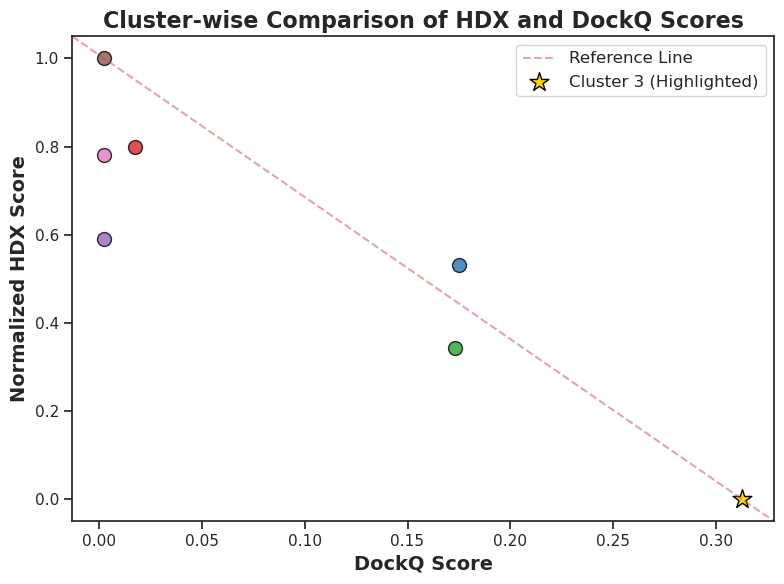

In [114]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

scaler = MinMaxScaler()

mean_values = (
    merge_df.groupby('Cluster')[['HDX_score', 'max_dockq']]
    .mean()
    .reset_index()
)
mean_values['HDX_score'] = scaler.fit_transform(mean_values[['HDX_score']])
display(mean_values)
highlight_cluster = mean_values.loc[mean_values['max_dockq'].idxmax(), 'Cluster']

plt.figure(figsize=(8, 6))
sns.set(style="ticks")
palette = iter(sns.color_palette("tab10", n_colors=mean_values['Cluster'].nunique()-1))
for index, row in mean_values.iterrows():
    if row['Cluster'] == highlight_cluster:
        plt.scatter(
            row['max_dockq'], 
            row['HDX_score'], 
            s=200, 
            color='gold', 
            edgecolor='black', 
            marker='*', 
            label=f'Cluster {int(row["Cluster"])} (Highlighted)'
        )
    else:
        set_color = cluster_color_map[int(row['Cluster'])]
        plt.scatter(
            row['max_dockq'], 
            row['HDX_score'], 
            s=100, 
            color=set_color, 
            edgecolor='black', 
            alpha=0.8
        )

plt.plot([0, 1], [1, 0], transform=plt.gca().transAxes, color='r', linestyle='--', alpha=0.5, label="Reference Line")

plt.ylabel('Normalized HDX Score', fontsize=14, fontweight='bold')
plt.xlabel('DockQ Score', fontsize=14, fontweight='bold')
plt.title("Cluster-wise Comparison of HDX and DockQ Scores", fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig(f'/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/AF_50/AF_Cluster_Comparison.png', dpi=300, transparent=False)

In [ ]:
import shutil

dst_dir = f'/home/lwang/models/HDX_LSTM/data/Cov19_icoHu23/ZRank2_top50'

for i, index in enumerate(clusters):
    if not os.path.exists(f'{dst_dir}/{spike_protein}/cluster{index}'):
        os.makedirs(f'{dst_dir}/{spike_protein}/cluster{index}')
    paths = pdb_fpaths[i].split('/')
    dst_file = f"{dst_dir}/{spike_protein}/cluster{index}/{paths[-2]+'_'+paths[-1]}"
    shutil.copyfile(pdb_fpaths[i], dst_file)